<font size='5'>Dla uproszczenia zakładamy, że długość zapytania odpowiada długości sekwencji przetwarzanej przez model. Nie uwzględniamy zatem uzupełniania sekwencji pustymi elementami (padding). Długość sekwencji wyrażona jest liczbą elementów (tokens), na które dzielony jest tekst. 
<br> - O co chodzi z "Nie uwzględniamy zatem uzupełniania sekwencji pustymi elementami (padding)"??
<br> - Więc rozumiem to tak, że jak ustalamy, że wejście ma x elementów, to możemy dać zapytania tylko 10 elementowe. A jeden element(token) to jeden znak, czyli input = x znaków.
<br> - Skoro na wyjściu dostajemy jeden element i potem doklejamy go nawejście usuwając pierwszy, to w którym momencie przerywamy ten proces, np. na wejście dajemy "ala ma kota, a kot ma" i oczekujemy wyjścia "ale". Ale w innym przypadku możemy oczekiwać słowa o innej długości. To bardziej do tego jak model ma być wykorzystany, bo jeśli dobrze rozumiem w trenowaniu jest łatwiej bo oczekujemy tylko kolejnego jednego znaku.
<br> - Czym jest wymiar przetwarzanego osadzenia w LSTM?
<br> - Czym wgl są osadzenia wejściowe> "Do utworzenia osadzeń wejściowych należy wykorzystać moduł Embedding dostępny w bibliotece PyTorch"
<br> - Każdy element dostaje unikalny identyfikator - liczbę, czyli, np. 'a' = 1. 'b' = 2, 'c' = 3, itp. CO ZE ZNAKAMI SPECJALNYMI, np. kropka, przecinek, spacja.
<br> - Czyli na wejście modelu dajemy sekwencje tych identyfikatorów np. 1 5 7 8 3 1 5 7 i na wyjściu też będzie identyfikator
<br> - Skoro na wyjściu z LSTM mamy oczekiwać sekwencjo elementów o takiej samej długości jak wejściowa tylko, np. przesuniętej o 1 element to po co jeszcze daje się warstwę liniową z prawdopodobieństwem danych elementów skoro wiadomo jaki element oczekujemy. EDIT: OKEJ CHYBA WIEM BO DO UCZENIA MODELU INFORMACJA O DOBRYM LUB ZŁYM SŁOWIE NIC NAM NIE POWIE A JAK BĘDZIEMY MIELI WARSTWĘ LINIOWĄ Z OCZEKIWANYM WYJŚCIEM TO TO NAM SIĘ POZWOLI SIĘ UCZYĆ</size>

Czytamy tekst i generujemy pary wejście (sekwencja znaków) -> wyjście (pojedynczy znak). Następnie, aby za każdym razem nie generować.

In [29]:
# Open the file in read mode
with open('pantadeusz.txt', 'r', encoding='utf-8') as file:
    # Read the entire content as a single string
    content_string = file.read().lower()

In [30]:
len(content_string), content_string[:20]

(445640, 'księga pierwsza\n\n\n\ng')

In [31]:
N = 100 # długość sekwencji wejściowej

In [32]:
list_of_pairs_input_output = []

for i in range(len(content_string) - N - 1):  # przechodzimy po wszytskich elementach, ale ostatni element zaczyna się na -N pozycji i -1 element na output
    one_pair = []
    one_pair.append([char for char in content_string[i:i + N]]) # N elementowa sekwencja wejściowa, np. znaki 0-49
    one_pair.append(content_string[i + N]) # wyjście z modelu, czyli jeden znak po sekwencji wejściowej, np znak 50
    list_of_pairs_input_output.append(one_pair)

In [33]:
# Open the file in write mode
with open(f'input_output_pairs_{N}.txt', 'w', encoding='utf-8') as file:
    # Write each element on a new line
    for item in list_of_pairs_input_output:
        file.write(str(item) + '\n')

In [34]:
import json

def read_dict_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        loaded_dict = json.load(file)
    return loaded_dict

In [35]:
dict = read_dict_from_file('dict.txt')

In [36]:
# placeholder funkcja do kodowania znaków na identyfikatory ze słownika
def encodeCharacter(character):
    return dict[character]

In [37]:
list_of_pairs_input_output_coded = []

for elem in list_of_pairs_input_output:
    one_pair =[]
    one_pair.append([encodeCharacter(char) for char in elem[0]])
    one_pair.append(encodeCharacter(elem[1]))
    list_of_pairs_input_output_coded.append(one_pair)

In [38]:
# Open the file in write mode
with open(f'input_output_pairs_encoded_{N}.txt', 'w', encoding='utf-8') as file:
    # Write each element on a new line
    for item in list_of_pairs_input_output_coded:
        file.write(str(item) + '\n')

In [39]:
lenDataset = len(list_of_pairs_input_output_coded)

In [40]:
train, valid, test = split_data(list_of_pairs_input_output_coded)

NameError: name 'split_data' is not defined

In [ ]:
len(train), len(train[0][0]), train[0][1]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import json
import random

torch.manual_seed(1)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

In [ ]:
class LSTMTextGenerator(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, n_layers, vocab_size=len(dict)):
        super(LSTMTextGenerator, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.word_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, X_batch):
        embeddings = self.word_embedding(X_batch)

        hidden, carry = torch.randn(self.n_layers, len(X_batch), self.hidden_dim).to(device), torch.randn(self.n_layers, len(X_batch), self.hidden_dim).to(device)
        output, (hidden, carry) = self.lstm(embeddings, (hidden, carry))
        return self.linear(output[:,-1])

In [ ]:
def TrainModel(model, loss_fn, optimizer, train_loader, epochs=10):
    losses = []
    for i in range(epochs):
        for X, Y in train_loader:
            Y_preds = model(X.to(device))

            loss = loss_fn(Y_preds, Y.to(device))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
    return losses

In [ ]:
def TestModel(model, test_loader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for X, Y in test_loader:
            X, Y = X.to(device), Y.to(device)  # Move both input and target to the same device
            output = model(X)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(Y.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

In [ ]:
def read_list_of_lists_from_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    list_of_lists = []
    for line in lines:
        line = line.strip()
        list_with_count = eval(line)
        list_of_lists.append(list_with_count)
 
    return list_of_lists

In [ ]:
def split_data(data, train_ratio=0.75, test_ratio=0.25):     
    total_size = len(data)     
    train_size = int(total_size * train_ratio)              
    random.shuffle(data)          
    train_data = data[:train_size]     
    test_data = data[train_size:]              
    return train_data, test_data

In [ ]:
EMBEDDING_DIM = [50, 100]
HIDDEN_DIM = [128, 256]
LSTM_LAYERS = [1, 2]
EPOCHS = [10, 50]
SEQUENCE_LENGTH = [50, 100]

In [24]:
def prepareData(data):
    X_train = [elem[0] for elem in data]
    Y_train = [elem[1] for elem in data]
    X_train, Y_train = torch.tensor(X_train, dtype=torch.int32), torch.tensor(Y_train)
    vectorized_train_dataset = TensorDataset(X_train, Y_train)
    return DataLoader(vectorized_train_dataset, batch_size=64, shuffle=False)

In [37]:
results = []
for n in SEQUENCE_LENGTH:
    list_of_pairs_input_output_coded = read_list_of_lists_from_file(f'input_output_pairs_encoded_{n}.txt')
    train, test = split_data(list_of_pairs_input_output_coded)
    with open(f'train_{n}.txt', 'w', encoding='utf-8') as file:
        for item in train:
            file.write(str(item) + '\n')
    
    with open(f'test_{n}.txt', 'w', encoding='utf-8') as file:
        for item in test:
            file.write(str(item) + '\n')
            
    train_loader = prepareData(train)
    test_loader = prepareData(test)
    for e_d in EMBEDDING_DIM:
        for h_d in HIDDEN_DIM:
            for lstm_l in LSTM_LAYERS:
                for epoch in EPOCHS:
                    print(f"EMBEDDING_DIM': {e_d}, 'SEQUENCE_LENGTH': {n}, 'HIDDEN_DIM': {h_d}, 'LSTM_LAYERS': {lstm_l}, 'EPOCHS': {epoch}")
                    model = LSTMTextGenerator(e_d, h_d, lstm_l).to(device)
                    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
                    loss_list = TrainModel(model, loss_function, optimizer, train_loader, epoch)
                    accuracy = TestModel(model, test_loader, device)
                    print(accuracy)
                    param_grid = {
                        'EMBEDDING_DIM': e_d,
                        'SEQUENCE_LENGTH': n,
                        'HIDDEN_DIM': h_d,
                        'LSTM_LAYERS': lstm_l,
                        'EPOCHS': epoch,
                        'LOSS_LIST': loss_list,
                        'ACCURACY': accuracy
                    }
                    torch.save(model.state_dict(), f'text_gen_lstm_n{n}_emDim{e_d}_hidDim{h_d}_lay{lstm_l}_ep{epoch}.pth')
                    results.append(param_grid)
with open('results.txt', 'w', encoding='utf-8') as file:
    for item in results:
        file.write(str(item) + '\n')


EMBEDDING_DIM': 50, 'SEQUENCE_LENGTH': 50, 'HIDDEN_DIM': 128, 'LSTM_LAYERS': 1, 'EPOCHS': 10
40.90109337690084
EMBEDDING_DIM': 50, 'SEQUENCE_LENGTH': 50, 'HIDDEN_DIM': 128, 'LSTM_LAYERS': 1, 'EPOCHS': 50
46.72256234402772
EMBEDDING_DIM': 50, 'SEQUENCE_LENGTH': 50, 'HIDDEN_DIM': 128, 'LSTM_LAYERS': 2, 'EPOCHS': 10
41.59051329467315
EMBEDDING_DIM': 50, 'SEQUENCE_LENGTH': 50, 'HIDDEN_DIM': 128, 'LSTM_LAYERS': 2, 'EPOCHS': 50
48.226180003231654
EMBEDDING_DIM': 50, 'SEQUENCE_LENGTH': 50, 'HIDDEN_DIM': 256, 'LSTM_LAYERS': 1, 'EPOCHS': 10
43.54566509273057
EMBEDDING_DIM': 50, 'SEQUENCE_LENGTH': 50, 'HIDDEN_DIM': 256, 'LSTM_LAYERS': 1, 'EPOCHS': 50
47.90121905240669
EMBEDDING_DIM': 50, 'SEQUENCE_LENGTH': 50, 'HIDDEN_DIM': 256, 'LSTM_LAYERS': 2, 'EPOCHS': 10
46.15971561428392
EMBEDDING_DIM': 50, 'SEQUENCE_LENGTH': 50, 'HIDDEN_DIM': 256, 'LSTM_LAYERS': 2, 'EPOCHS': 50
45.334745686637106
EMBEDDING_DIM': 100, 'SEQUENCE_LENGTH': 50, 'HIDDEN_DIM': 128, 'LSTM_LAYERS': 1, 'EPOCHS': 10
42.4460044165963

In [197]:
model = LSTMTextGenerator(EMBEDDING_DIM, HIDDEN_DIM, LSTM_LAYERS).to(device)
if torch.cuda.is_available():
    model.cuda()
loss_function = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 5

In [41]:
# dekoduje sekewncje kodów na tekst
def decode(dictionary, target_value):
    for key, value in dictionary.items():         
        if value == target_value:             
            return key     
    # return None  # Return None if the value is not found 

In [42]:
random.seed(123)
idx = random.randint(0, len(X_train))
pattern = X_train[12].numpy().astype(int).flatten().tolist()

input_text = "".join([decode(dict, value) for value in pattern])

print("Input : {}".format(input_text))

generated_text = []
for i in range(10):
    X_batch = torch.tensor(pattern, dtype=torch.int32).reshape(1, N) ## Design Batch
    preds = model(X_batch.to(device)) ## Make Prediction
    predicted_index = preds.argmax(dim=-1).cpu().numpy()[0] ## Retrieve token index
    generated_text.append(predicted_index) ## Add token index to result
    pattern.append(predicted_index) ## Add token index to original pattern
    pattern = pattern[1:] ## Resize pattern to bring again to seq_length length.

output_text = "".join([decode(dict, value) for value in generated_text])
print("Generated Text : {}".format(output_text))

AttributeError: 'list' object has no attribute 'numpy'

In [1]:
loss = [2.3427491188049316, 2.1163644790649414, 2.025970458984375, 1.9677507877349854, 1.9241502285003662, 1.8917900323867798, 1.8706796169281006, 1.85259211063385, 1.822340965270996, 1.800827980041504, 1.785904884338379, 1.773327112197876, 1.7619396448135376, 1.7586133480072021, 1.7434463500976562, 1.736501932144165, 1.7229843139648438, 1.707581877708435, 1.696311593055725, 1.684746503829956, 1.671386957168579, 1.6637136936187744, 1.6482652425765991, 1.6323105096817017, 1.62392258644104, 1.6080700159072876, 1.5931646823883057, 1.570953369140625, 1.5479106903076172, 1.5226476192474365, 1.515092134475708, 1.4866410493850708, 1.4745091199874878, 1.4520461559295654, 1.440665364265442, 1.4248965978622437, 1.4094384908676147, 1.4045100212097168, 1.391408920288086, 1.3870904445648193, 1.3774282932281494, 1.3670915365219116, 1.3607975244522095, 1.3533804416656494, 1.3451573848724365, 1.3355484008789062, 1.3207018375396729, 1.3116521835327148, 1.3069690465927124, 1.295594573020935]

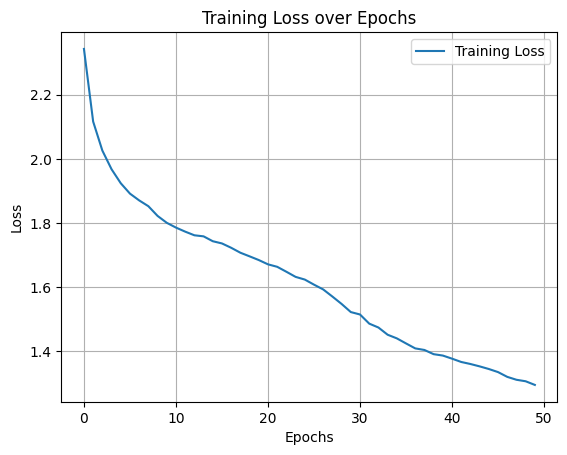

In [5]:
import matplotlib.pyplot as plt
# Generating x-axis values for epochs (assuming you have 50 epochs)
epochs = list(range(50))  # Adjust the range according to your actual number of epochs

# Plotting the loss values
plt.plot(epochs, loss, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
import ast

# Read the contents of the file
file_path = 'results.txt'  # Replace with the actual file path
with open(file_path, 'r') as file:
    file_contents = file.read()

# Safely evaluate the contents using ast.literal_eval
data_list = ast.literal_eval(file_contents)

# Now, data_list contains the list of dictionaries
for data in data_list:
    print(data)

SyntaxError: invalid syntax (<unknown>, line 2)

In [99]:
test_data = read_list_of_lists_from_file('test_100.txt')

 = [elem[0] for elem in test_data]
Y_train = [elem[1] for elem in test_data]

In [129]:
model = LSTMTextGenerator(50, 128, 2)
model.load_state_dict(torch.load('text_gen_lstm_n100_emDim50_hidDim128_lay2_ep50.pth'))



<All keys matched successfully>

In [131]:
model = LSTMTextGenerator(100, 128, 2)
model.load_state_dict(torch.load('text_gen_lstm_n100_emDim100_hidDim128_lay2_ep50.pth'))

<All keys matched successfully>

In [132]:
if torch.cuda.is_available():
    model.cuda()
import copy

random.seed(123)
idx = random.randint(0, len(X_train))
deep_copy_list = copy.deepcopy(X_train[1])
pattern = deep_copy_list

input_text = "".join([decode(dict, value) for value in pattern])

print("Input : {}".format(input_text))

generated_text = []
for i in range(100):

    X_batch = torch.tensor(pattern, dtype=torch.int32).reshape(1, N) ## Design Batch
    preds = model(X_batch.to('cuda')) ## Make Prediction
    predicted_index = preds.argmax(dim=-1)[0] ## Retrieve token index
    generated_text.append(predicted_index) ## Add token index to result
    pattern.append(predicted_index) ## Add token index to original pattern
    pattern = pattern[1:] ## Resize pattern to bring again to seq_length length.

output_text = "".join([decode(dict, value) for value in generated_text])
print("Generated Text : {}".format(output_text))

Input :  zostaniesz przez resztę żywota
bardzo samotny, stary, wdowiec i sierota!
powiedz, czym ci ten drogi
Generated Text :  z pole starego szabał,
i w polskie stary podkomorzy w stole podkomu,
i z polak wielkie stary pod st


In [133]:
if torch.cuda.is_available():
    model1.cuda()


random.seed(123)
idx = random.randint(0, len(X_train))
deep_copy_list = copy.deepcopy(X_train[1])
pattern = deep_copy_list

input_text = "".join([decode(dict, value) for value in pattern])

print("Input : {}".format(input_text))

generated_text = []
for i in range(100):

    X_batch = torch.tensor(pattern, dtype=torch.int32).reshape(1, N) ## Design Batch
    preds = model1(X_batch.to('cuda')) ## Make Prediction
    predicted_index = preds.argmax(dim=-1)[0] ## Retrieve token index
    generated_text.append(predicted_index) ## Add token index to result
    pattern.append(predicted_index) ## Add token index to original pattern
    pattern = pattern[1:] ## Resize pattern to bring again to seq_length length.

output_text = "".join([decode(dict, value) for value in generated_text])
print("Generated Text : {}".format(output_text))

Input :  zostaniesz przez resztę żywota
bardzo samotny, stary, wdowiec i sierota!
powiedz, czym ci ten drogi
Generated Text :  serwis potem —
rzekł sędzia — ja przeproszą wojskiego soplicy!
koło już minni! jesteś to mi serca n
